<a href="https://colab.research.google.com/github/bits-mtech/DL/blob/main/Assignment_2/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [266]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [267]:
!pip install split-folders[full]
DRIVE_PATH = "/content/drive/MyDrive/Colab_Notebooks/"
DRIVE_IMAGE_PATH = DRIVE_PATH + "Image/Flicker8k_Dataset/"

In [268]:
#!pip install cloud-tpu-client==0.10 torch==1.10.0+cu111 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [269]:
# Import Libraries
# - Tensorflow
# - Keras
# - numpy and random

import tensorflow as tf
from keras import models
from keras import layers

import random
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pickle 
import re
import splitfolders

from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import adam_v2
from time import time
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import keras

import gensim
from gensim.models import Word2Vec

print('keras: %s' % keras.__version__)
print('tensorflow: %s' % tf.__version__)

keras: 2.8.0
tensorflow: 2.8.0


In [270]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(42)  # sets the graph-level random seed

In [271]:
# Read the data from the file 
# First make sure you put the file in below mentioned path from shared folder

with open(DRIVE_PATH + 'set_1.pkl', 'rb') as fid:
     data3 = pickle.load(fid)

In [272]:
#data3
#!unzip /content/drive/MyDrive/Colab_Notebooks/Image_captioning_Dataset.zip -d /content/drive/MyDrive/Colab_Notebooks/Image

In [273]:
image_list = []
comment_list = []
comment_id_list = []
for line in data3:
  a = re.split('[?#\t]', line)
  image_list.append(a[0])
  comment_id_list.append(a[1])
  comment_list.append(a[2])
# intialise data of lists.
data = {'image':image_list, 'comment_id':comment_id_list, 'comment': comment_list}
 
def add_path(x):
  return f"{DRIVE_IMAGE_PATH}{x}" 

# Create DataFrame
df = pd.DataFrame(data)
df['image_path'] = df["image"].apply(lambda x: add_path(x) )
df.sort_values(by=['image','comment_id'],inplace=True)
df.reset_index()
df.head(10)

,image,comment_id,comment,image_path
10060,1000268201_693b08cb0e.jpg,0,A child in a pink dress be climb up a set of s...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
9037,1000268201_693b08cb0e.jpg,1,A girl go into a wooden building .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17952,1000268201_693b08cb0e.jpg,2,A little girl climb into a wooden playhouse .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
20907,1000268201_693b08cb0e.jpg,3,A little girl climb the stair to her playhouse .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22408,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress go into a wooden...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
3144,1001773457_577c3a7d70.jpg,1,A black dog and a tri-colored dog play with ea...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22138,1001773457_577c3a7d70.jpg,2,A black dog and a white dog with brown spot be...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
23829,1001773457_577c3a7d70.jpg,4,Two dog on pavement move toward each other .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22788,1002674143_1b742ab4b8.jpg,1,A little girl be sit in front of a large paint...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17907,1002674143_1b742ab4b8.jpg,3,There be a girl with pigtail sit in front of a...,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [274]:
df.loc[df['image'].str.contains(".jpg."),'image']= '2258277193_586949ec62.jpg'
df.drop(df[df['image']=='2258277193_586949ec62.jpg'].index,inplace=True)
df[df['image']=='2258277193_586949ec62.jpg']

,image,comment_id,comment,image_path


In [275]:
#Check the Dataset property
print('length of data is', len(df))
df.describe()

length of data is 24996


,image,comment_id,comment,image_path
count,24996,24996,24996,24996
unique,8032,5,24815,8032
top,1000268201_693b08cb0e.jpg,4,Two dog play in the snow .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
freq,5,5037,9,5


In [276]:
# Check the Null Values in dataset
print('length of null value in train data is', df.isnull().any().sum())

length of null value in train data is 0


In [277]:
# Check the of unique image count
print(f'Number of unique images in dataset {df["image"].nunique()}')

Number of unique images in dataset 8032


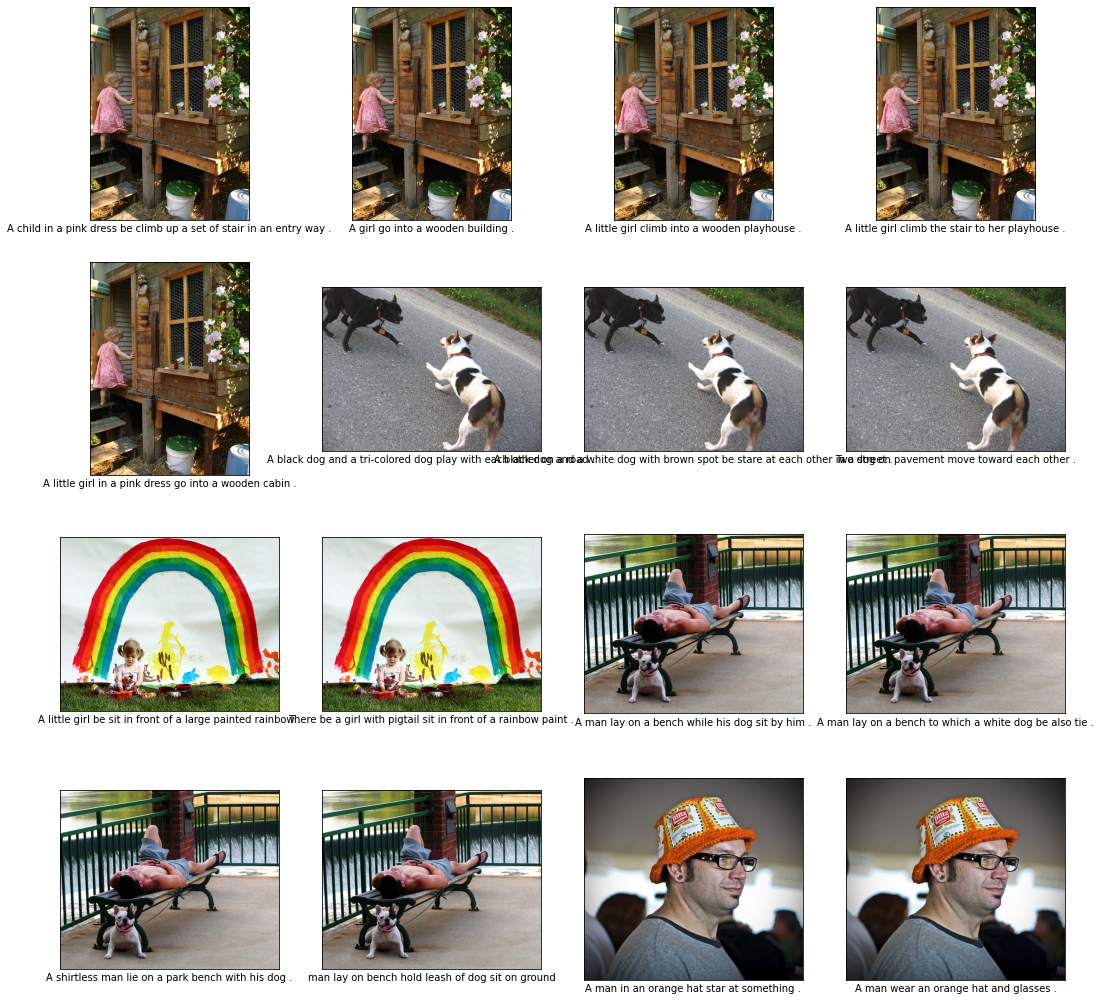

In [278]:
# Plot the Smaple image and its caption from dataset

plt.figure(figsize=(18,18))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = plt.imread(df["image_path"].iloc[i])
    plt.imshow(img)
    plt.xlabel(df["comment"].iloc[i])
plt.show()

In [279]:
def get_files_from_folder(path):

    files = os.listdir(path)
    return np.asarray(files)

file_list = get_files_from_folder(DRIVE_IMAGE_PATH)
print(len(file_list))

8091


In [280]:
!pip install tweet-preprocessor
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [295]:
lemma = nltk.stem.WordNetLemmatizer()

def load_decriptions(doc):
    mapping = dict()
    
    for i in range(len(doc)):
        image_id = doc['image'].iloc[i]
        image_desc = doc['comment'].iloc[i]
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)
    
    # tokenize the words
    desc = desc.split()
    
    # convert to lower case
    desc = [token.lower() for token in desc]
    
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

# convert loaded descriptions into vocablury
def to_vocabluary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    return all_desc

def save_descriptions(descriptions , filename):
    lines = list()
    
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(filename , 'w')
    file.write(data)
    file.close()         

In [282]:
clean_text("A cat is sitting over the house # 64")

'a cat is sitting over the house'

In [293]:
df['comment'] = df['comment'].apply(lambda x : clean_text(str(x)))
df.sample(6)

,image,comment_id,comment,image_path
9486,3130093622_362f32f2bb.jpg,2,a dog run with a stick in the snow,/content/drive/MyDrive/Colab_Notebooks/Image/F...
8513,3445544288_68fdb25969.jpg,3,two person be ride a ski lift with mountain be...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
21576,496606439_9333831e73.jpg,4,two woman in front of box of tea and cup,/content/drive/MyDrive/Colab_Notebooks/Image/F...
11321,2121357310_f8235311da.jpg,1,a boy slide down a water slide a another boy r...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
23382,2613993276_3c365cca12.jpg,2,a dog with a ball that be run in a field,/content/drive/MyDrive/Colab_Notebooks/Image/F...
18687,2729685399_56c0e104b1.jpg,2,three person talk on a city street,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [296]:
desc_map = load_decriptions(df) # image name with Its captions
vocabulary = to_vocabluary(desc_map)
print(len(vocabulary))
print(desc_map.get('1042020065_fb3d3ba5ba.jpg'))

5385
['a boy in a green shirt be look down at many inflatable boat', 'a boy look over a railing at the many boat and raft below in the water', 'a young boy overlook a crowd of inflatable boat', 'a young boy wear a jersey look down over a ledge at many boat in the water']


In [297]:
# Vocab

vocab = set()
for key in desc_map.keys():
    [vocab.update(sentence.split()) for sentence in desc_map[key]]
    
print("Vocab Size : %d"% len(vocab))

# Total No of words across all the sentences
total_words = []

for key in desc_map.keys():
    [total_words.append(i) for des in desc_map[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Vocab Size : 5385
Total Words 268519


In [298]:
# Filter Words from the Vocab according to certain threshold frequncy
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))

5385


In [299]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

print(len(total_words)) # 1150 unique words filter, this is going to be new vocab size

1150


In [300]:
max_len = 0 
for key in desc_map.keys():
    for cap in desc_map[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [301]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    cnt = i+1
    word_to_idx[word] = cnt
    idx_to_word[cnt] = word
print(len(word_to_idx.keys()))
print(len(idx_to_word.keys()))

# Two special words
idx_to_word[1150] = 'startseq'
word_to_idx['startseq'] = 1152

idx_to_word[1150] = 'endseq'
word_to_idx['endseq'] = 1153

vocab_size = len(word_to_idx.items()) + 1
print("Vocab Size",vocab_size)

1150
1150
Vocab Size 1153


In [302]:
save_descriptions(desc_map , f'{DRIVE_PATH}descriptions.txt')

In [303]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img
  
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()
#Since we only need image features
model_new = Model(model.input,model.layers[-2].output)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_44[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [94]:
# Testing image encodings
encode_image(DRIVE_IMAGE_PATH+"1000268201_693b08cb0e.jpg")

array([0.0653593 , 0.16782546, 0.32517618, ..., 0.05107123, 0.32821232,
       1.004337  ], dtype=float32)

In [ ]:
# This Step will take around 30 -40  minutes so refrain from running it.
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,rec in enumerate(file_list):
    encoding_train[rec] = encode_image(f'{DRIVE_IMAGE_PATH}{rec}')
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)
df.head()

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

,image,comment_id,comment,image_path
10060,1000268201_693b08cb0e.jpg,0,a child in a pink dress be climb up a set of s...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
9037,1000268201_693b08cb0e.jpg,1,a girl go into a wooden building,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17952,1000268201_693b08cb0e.jpg,2,a little girl climb into a wooden playhouse,/content/drive/MyDrive/Colab_Notebooks/Image/F...
20907,1000268201_693b08cb0e.jpg,3,a little girl climb the stair to her playhouse,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22408,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress go into a wooden...,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [ ]:
# Store everything to the disk 
# with open(f"{DRIVE_PATH}encoded_features.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

## Train Test Split

In [243]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.15)
print("Shape of training data is",train.shape)
print("Shape of testing data is",test.shape)

Shape of training data is (21250, 4)
Shape of testing data is (3750, 4)


In [244]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train

,image,comment_id,comment,image_path
6190,1510669311_75330b4781.jpg,0,a group of girl be pose together with male nearby,/content/drive/MyDrive/Colab_Notebooks/Image/F...
5952,1491192153_7c395991e5.jpg,3,parent hold up a child over a swing,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17684,3534046564_4f8546e364.jpg,4,two dog face off of each other on the grass,/content/drive/MyDrive/Colab_Notebooks/Image/F...
13886,509778093_21236bb64d.jpg,4,a small brown dog paw at a white ball,/content/drive/MyDrive/Colab_Notebooks/Image/F...
1603,3420469425_2980b4cd30.jpg,1,a couple stadning with their child get baptize...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
...,...,...,...,...
11670,3717309680_e5105afa6d.jpg,4,four motorcycle be race on a dirt track,/content/drive/MyDrive/Colab_Notebooks/Image/F...
562,2410153942_ba4a136358.jpg,1,a red and white car be overturn on a dirt track,/content/drive/MyDrive/Colab_Notebooks/Image/F...
11133,1312020846_5abb4a9be2.jpg,1,two puppy run across flat stone in garden area,/content/drive/MyDrive/Colab_Notebooks/Image/F...
20945,3335692531_dd4a995f91.jpg,1,three dog be all tug on the same toy a they st...,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [34]:
!pip install gensim
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-03-16 11:23:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-16 11:23:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-16 11:23:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [304]:
f = open("glove.6B.50d.txt",encoding='utf8')
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
f.close()


def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for id,(word,idx) in enumerate(word_to_idx.items()):
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[id] = embedding_vector
            
    return matrix

embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1153, 50)

In [308]:
input_img_features = Input(shape=(2048))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# # Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix],)
model.layers[2].trainable = False

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, 35, 50)       57650       ['input_52[0][0]']               
                                                                                                  
 dropout_44 (Dropout)           (None, 2048)         0           ['input_51[0][0]']               
                                                                                           

In [309]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [310]:
epochs = 20
batch_size = 3
steps = len(desc_map)

with open(f"{DRIVE_PATH}encoded_features.pkl","rb") as f:
    encoding_train = pickle.load(f)

def train():
    for i in range(epochs):
        generator = data_generator(desc_map,encoding_train,word_to_idx,max_len,batch_size)
        model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save(f'{DRIVE_PATH}model_'+str(i)+'.h5')

In [311]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = keras.utils.all_utils.to_categorical([yi],num_classes=vocab_size)[0]
                    
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [ ]:
train() 

In [313]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

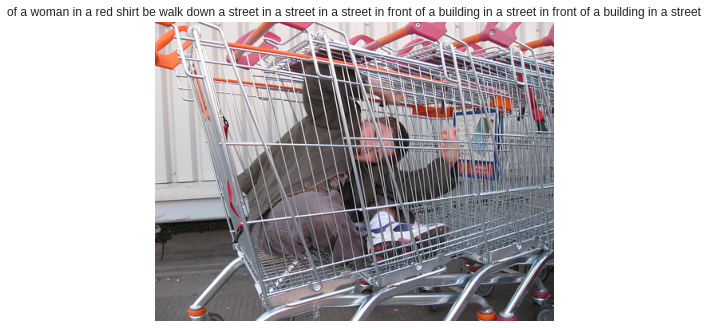

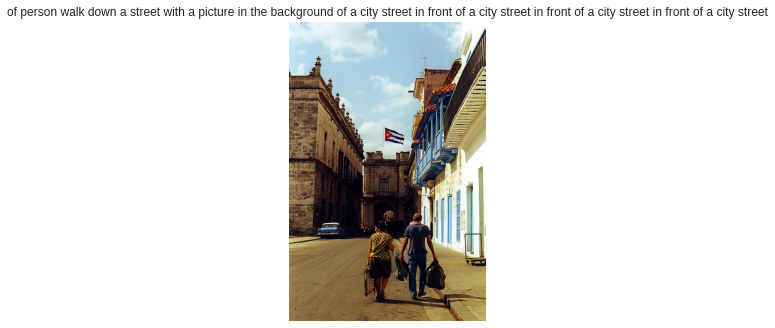

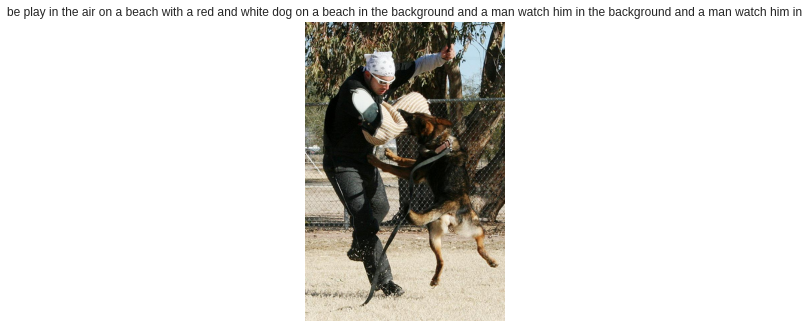

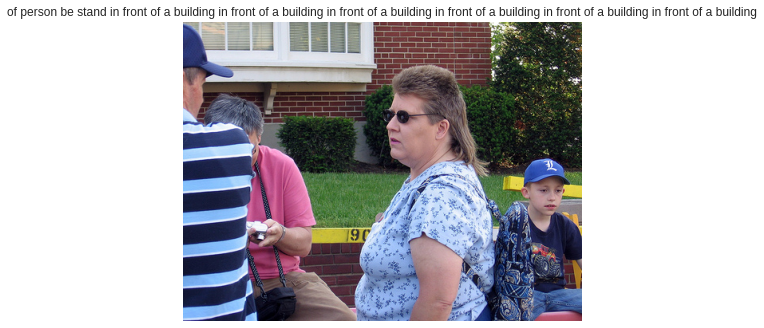

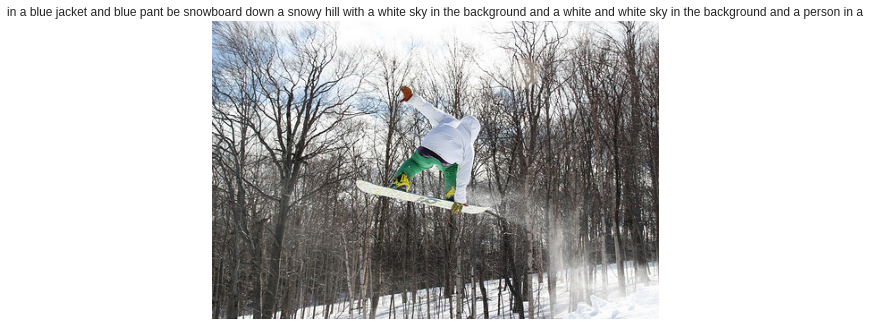

In [317]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(5):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_train.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_train[img_name].reshape((1,2048))
    i = plt.imread(f"{DRIVE_IMAGE_PATH}{img_name}")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

0


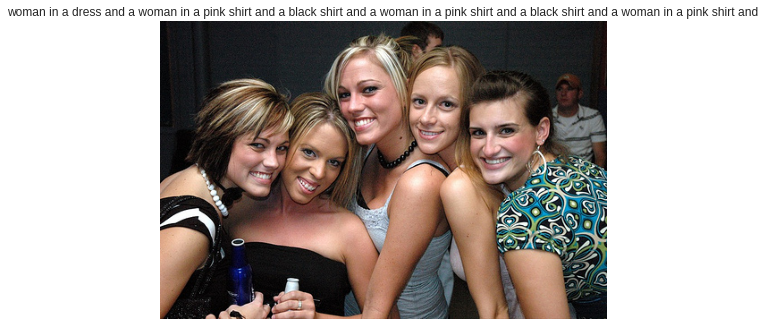

In [320]:
##Evaluation
from nltk.translate.bleu_score import sentence_bleu


temp=encode_image(f"{DRIVE_IMAGE_PATH}1510669311_75330b4781.jpg")
pict=plt.imread(f"{DRIVE_IMAGE_PATH}1510669311_75330b4781.jpg")
temp2=temp.reshape((1,2048))
caption=predict_caption(temp2)
plt.title(caption)
plt.imshow(pict)
plt.axis("off")

reference = [['women','man','nearby','running','over','mountain']]
candidate = [i for i in caption.split()]
sc=sentence_bleu(reference, candidate)
print(sc)